Apply inverse transform

In [128]:
import numpy as np
from tqdm import tqdm
import nibabel as nib
import numpy.linalg as npl
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from sklearn.linear_model import LinearRegression

def fit_warp_field(warp_field):
    # Get warp field dimensions
    len_i, len_j, len_k, len_coords = warp_field.shape

    # Create 3D grid for voxel indices
    i, j, k = np.meshgrid(
        np.arange(len_i),
        np.arange(len_j),
        np.arange(len_k),
        indexing='ij'  # Ensures correct shape alignment
    )

    # Flatten indices and warp field components
    i_flat = i.ravel()
    j_flat = j.ravel()
    k_flat = k.ravel()

    # Prepare input (IVs) and output (DVs)
    IVs = np.vstack([i_flat, j_flat, k_flat]).T  # Shape [num_voxels, 3]

    for coordinate in tqdm(range(len_coords)):
        # Flatten the warp field for the current coordinate
        coord_flat = warp_field[..., coordinate].ravel()
        is_nan = np.isnan(coord_flat)
        not_nan = ~is_nan
        # Fit the model using valid (non-NaN) data
        model = LinearRegression().fit(IVs[not_nan], coord_flat[not_nan])
        # Predict values for NaN positions and replace
        coord_flat[is_nan] = model.predict(IVs[is_nan])
        # Update the warp field with the corrected values
        warp_field[..., coordinate] = coord_flat.reshape(len_i, len_j, len_k)

    return warp_field

def plot(img_data, inversed_img):
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(inversed_img[inversed_img.shape[2] // 2, :, :], cmap='gray')
    axes[0].set_title("Warped Image Slice (Mid-Z)")
    axes[1].imshow(img_data[img_data.shape[2] // 2, :, :], cmap='gray')
    axes[1].set_title("Original Image Slice (Mid-Z)")
    plt.show()
    
def apply_inverse_deformation(nifti_path, inverse_transform_path, output_path):
    # Get the Trasnformed Image
    img = nib.load(nifti_path)
    img_data = img.get_fdata()
    print('Original data shape:', img_data.shape)
    print('Original Affine: \n', img.affine, '\n --- \n Inverted Affine: \n', npl.pinv(img.affine))  
    
    # Get the Inverse Warp Field -- stores magnitude data at each voxel (i,j,k) in the fourth dimension, where (0=x, 1=y, 2=z)
    # the fourth dimension is the TARGET MNI COORDINATE OF THE TRANSFORM. Thus, it tells you where to stick the Warped MNI coord
    # to put it back into unwarped MNI coord. 
    def_field_img = nib.load(inverse_transform_path)
    def_field_data = np.squeeze(def_field_img.get_fdata())  # Shape (I, J, K, 3); 
    def_field_data = fit_warp_field(def_field_data)         # Quick function to prevent nans in the warp field
    print('Def field data shape:', def_field_data.shape)
        
    # Invert the inverse MNI coordinates to find the voxelwise indices (ijk) corresponding to the unwarped data 
    # for i in range(0, img.affine.shape[-1]-1):
    #     img.affine[i,i] = -1 if i==0 else 1
    transform = nib.affines.apply_affine(npl.pinv(def_field_img.affine), def_field_data) #undo mni affine and warp field

    # Move data at warped image IJK to unwarped IJK
    vox2vox_mapping = transform.transpose(3, 0, 1, 2) # Transpose to (3, I, J, K) for map_coordinates compatibility
    inversed_img = map_coordinates(img_data, vox2vox_mapping, order=1, mode='nearest') # takes origin IJK and sticks em in target IJK location

    # Visualize & Save
    plot(img_data, inversed_img)
    nifti_out = nib.Nifti1Image(inversed_img, affine=def_field_img.affine)    # turn the array into a nifti
    nib.save(nifti_out, output_path)                                # save the result


Original data shape: (113, 137, 113)
Original Affine: 
 [[  -1.5    0.     0.    84. ]
 [   0.     1.5    0.  -120. ]
 [   0.     0.     1.5  -72. ]
 [   0.     0.     0.     1. ]] 
 --- 
 Inverted Affine: 
 [[-6.66666667e-01 -1.50990331e-14 -4.57966998e-15  5.60000000e+01]
 [-3.71924713e-14  6.66666667e-01 -6.46704912e-15  8.00000000e+01]
 [-2.23432384e-14 -1.29618538e-14  6.66666667e-01  4.80000000e+01]
 [-4.80084722e-16 -2.48065457e-16 -6.80878964e-17  1.00000000e+00]]


100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Def field data shape: (113, 137, 113, 3)


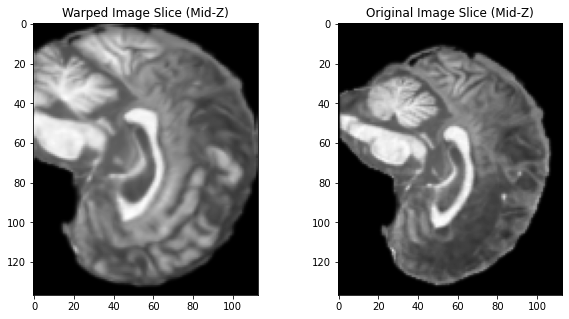

In [129]:
apply_inverse_deformation(nifti_path='/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/rimlf/hummingbird_for_shan/derivatives/mri/wmTeKe_T1_native.nii', 
                          inverse_transform_path='/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/atrophy_seeds_2023/shared_analysis/niftis_for_elmira/vbm_derivatives/mri/y_0002.nii', 
                          output_path='/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/rimlf/data/test/test.nii')

Resample Linearly

Resampled image saved to: /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/rimlf/data/test/test_to_pt.nii
